<a href="https://colab.research.google.com/github/AtSourav/AE-with-Continuous-Bernoulli/blob/main/AE_Continuous_Bernoulli_cats%26dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow import math
from keras import losses
from keras import layers
from keras import utils
from keras import backend as K

import os
import matplotlib.pyplot as plt


In [ ]:
#tf.config.set_soft_device_placement(True)   # needed when we want to use a TPU

#tf.debugging.enable_check_numerics()

In [ ]:
input_size = (64,64,3)
latent_dim = 512
batch_size = 512

In [ ]:
! git clone https://github.com/AtSourav/CatsnDogs_img_dataset.git

Cloning into 'CatsnDogs_img_dataset'...
remote: Enumerating objects: 10444, done.
remote: Counting objects: 100% (4705/4705), done.
remote: Compressing objects: 100% (4704/4704), done.
remote: Total 10444 (delta 3), reused 4697 (delta 1), pack-reused 5739
Receiving objects: 100% (10444/10444), 68.94 MiB | 19.19 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Updating files: 100% (5843/5843), done.


In [ ]:
img_dir = 'CatsnDogs_img_dataset/Dataset_aug/'
dir_size = len([imgs for imgs in os.listdir(img_dir)])

# we'll try to create one training dataset as one batch, and similarly for the validation dataset. These are dataset objects.
# We'll split the data into smaller batches while training with the fit() function.
# the images in the folder are 160 x 160 in size

data_train = utils.image_dataset_from_directory(img_dir, labels=None, validation_split=0.15, subset="training", seed=111, image_size=(160,160), color_mode='rgb', shuffle=True, batch_size=int(0.85*dir_size))

data_valid = utils.image_dataset_from_directory(img_dir, labels=None, validation_split=0.15, subset="validation", seed=111, image_size=(160,160), color_mode='rgb', shuffle=True, batch_size=int(0.15*dir_size))

for image_batch in data_train:
  print(image_batch.shape)
  break

for image_batch in data_valid:
  print(image_batch.shape)
  break


Found 5110 files belonging to 1 classes.
Using 4344 files for training.
Found 5110 files belonging to 1 classes.
Using 766 files for validation.
(4343, 160, 160, 3)
(766, 160, 160, 3)


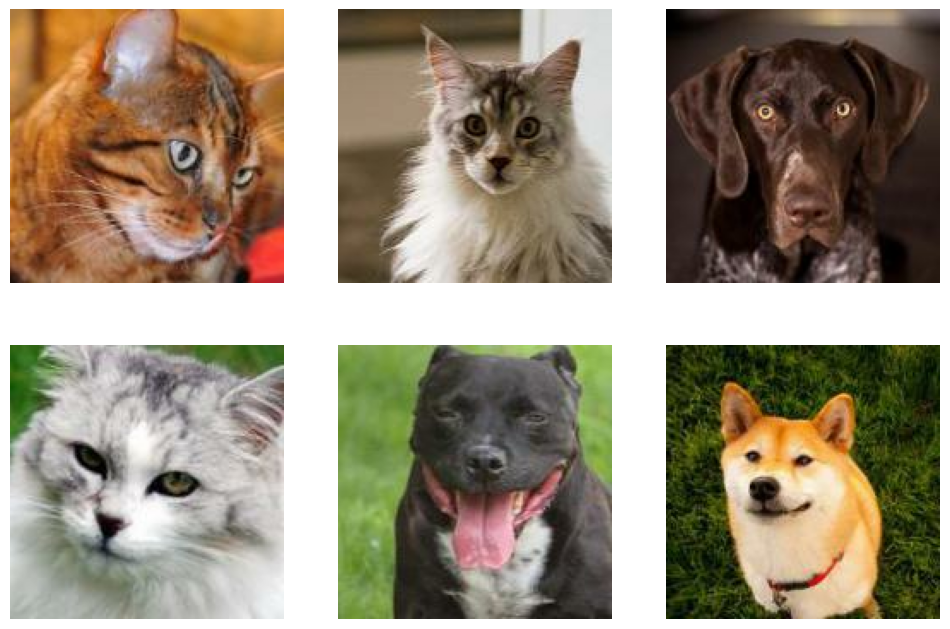

In [ ]:
visual = plt.figure(figsize=(12,8))

for image in data_train.take(1):            # Dataset.take(n) creates a TakeDataset using n items from the original dataset
  for i in range(6):
    visual.add_subplot(2,3,i+1)
    plt.imshow(image[i]/255)
    plt.axis('off')

In [ ]:
train_set = next(iter(data_train))
train_set = layers.Resizing(64, 64, interpolation="bilinear")(train_set)
train_set = train_set/255.            # to ensure pixel values between [0,1], it's better for neural networks to work on small numbers
print(train_set.shape)

valid_set = next(iter(data_valid))
valid_set = layers.Resizing(64, 64, interpolation="bilinear")(valid_set)
valid_set = valid_set/255.
print(valid_set.shape)

(4343, 64, 64, 3)
(766, 64, 64, 3)


In [ ]:
encoder_input = keras.Input(shape=input_size)

x = layers.Conv2D(8, 2, padding="same")(encoder_input)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(x)
x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(16, 2, padding="same")(x)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(x)
x = layers.ReLU()(x)

x = layers.Conv2D(32, 2, padding="same")(x)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(x)
x = layers.ReLU()(x)

x = layers.Conv2D(64, 2, padding="valid")(x)
x = layers.ReLU()(x)

x = layers.Conv2D(128, 2, padding="valid")(x)
x = layers.ReLU()(x)

x = layers.Conv2D(256, 2, padding="valid")(x)
x = layers.ReLU()(x)

x = layers.Conv2D(512, 2, padding="valid")(x)
x = layers.ReLU()(x)

x = layers.Conv2D(512, 2, padding="valid")(x)
x = layers.ReLU()(x)

x = layers.Conv2D(1024, 2, padding="valid")(x)
x = layers.ReLU()(x)

x = layers.Conv2D(1024, 2, padding="valid")(x)
x = layers.ReLU()(x)

x = layers.Flatten()(x)

x = layers.Dense(2*latent_dim)(x)
x = layers.ReLU()(x)


z = layers.Dense(latent_dim, name="z")(x)

encoder = keras.Model(encoder_input, z, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 8)         104       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 8)         0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 32, 32, 8)         32        
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 32, 32, 8)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 16)        528 

In [ ]:
latent_input = keras.Input(shape=(latent_dim,))

x = layers.Dense(1*1*1024)(latent_input)
x = layers.ReLU()(x)
x = layers.Reshape((1,1,1024))(x)

x = layers.Conv2DTranspose(1024, 2, strides=2, padding='same')(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(1024, 2, strides=2, padding='same')(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(512, 2, strides=2, padding='same')(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(512, 2, strides=2, padding='same')(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(256, 2, strides=2, padding='same')(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(64, 2, strides=1, padding='same')(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(32, 2, strides=1, padding='same')(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(16, 2, strides=1, padding='same')(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(8, 2, strides=1, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

decoder_output = layers.Conv2DTranspose(3, 2, activation='sigmoid', strides=1, padding='same')(x)

decoder = keras.Model(latent_input, decoder_output, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512)]             0         
                                                                 
 dense_1 (Dense)             (None, 1024)              525312    
                                                                 
 re_lu_11 (ReLU)             (None, 1024)              0         
                                                                 
 reshape (Reshape)           (None, 1, 1, 1024)        0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 2, 2, 1024)        4195328   
 anspose)                                                        
                                                                 
 re_lu_12 (ReLU)             (None, 2, 2, 1024)        0         
                                                           

Now let's instantiate the VAE by combininb the encoder and the decoder layers.

In [ ]:
decoder_out = decoder(encoder(encoder_input))
VAE = keras.Model(encoder_input, decoder_out, name='VAE')

VAE.summary()

Model: "VAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 encoder (Functional)        (None, 512)               9617016   
                                                                 
 decoder (Functional)        (None, 64, 64, 3)         12762235  
                                                                 
Total params: 22379251 (85.37 MB)
Trainable params: 22379219 (85.37 MB)
Non-trainable params: 32 (128.00 Byte)
_________________________________________________________________


In [ ]:
K.clear_session()

Our custom loss function will include the usual bce loss plus a normalisation term. We want to implement the same scheme of sums/averages taken across the different axes in the inbuilt bce term into the additional normalisation term. Bce as a standalone function averages across the pixel values, but does not sum/average across the batch axis.

In [ ]:
l_cutoff = 0.495       # these are hyperparameters
u_cutoff = 0.505       # for the range of values within these limits, we shall use the taylor expansion

def norm_CB(z):                                  # the norm of the Continuous Bernoulli loss function

    gate = math.logical_and(math.greater(z,l_cutoff), math.greater(u_cutoff,z))

    #z = tf.clip_by_value(z, clip_value_min = K.epsilon(), clip_value_max = 1 - K.epsilon())
    z_reg = tf.where(gate, l_cutoff, z)          # this is so the norm_reg below does not evaluate at z when z is close to the problematic value of z=0.5, otherwise we get NaNs. We use the taylor expansion to compute the loss at z=0.5 anyway.


    norm_reg = (2*math.atanh(1 - 2*z_reg))/(1 - 2*z_reg)         # this is the part meant to be used beyond the cutoff limits specified above
    norm_taylor = 2.0 + (8.0/3.0)*math.pow(z-0.5,2) + (32.0/5.0)*math.pow(z-0.5,4)  +  (128.0/7.0)*math.pow(z-0.5,6)          # the taylor expansion that we use within the cutoff limits


    norm = tf.where(gate, norm_taylor, norm_reg)          # when an element of gate is true, the corresponding element of norm_taylor is returned, otherwise the corresponding element of norm_reg is returned

    return norm

def CB_logloss(true, pred):
  true = layers.Flatten()(true)
  pred = layers.Flatten()(pred)
  bce = losses.binary_crossentropy(true,pred)

  corrected_loss_tensor = bce + tf.reduce_mean(math.log(norm_CB(pred)), axis=-1 )    # the binary cross entropy loss corrected with the normalisation factor
                                                                                    # the bce is built to average across the axes other than the batch axis, we do this for the norm manually

  return tf.reduce_mean(corrected_loss_tensor)            #  averaging across the batch axis



The initial contribution from the norm is about the same as the contribution from the usual bce term as the way the NNs are initiated puts the initial decoded pixel values around 0.5.

In [ ]:
optim = keras.optimizers.Adam(learning_rate = 0.0001)                  #, clipnorm=2.0
VAE.compile(optimizer=optim,loss=CB_logloss)

In [ ]:
history = VAE.fit(train_set, train_set, batch_size=batch_size, validation_data=(valid_set, valid_set), epochs=2, steps_per_epoch=None)


Epoch 1/2
9/9 [==============================] - 62s 3s/step - loss: 1.3860 - val_loss: 1.3862
Epoch 2/2
9/9 [==============================] - 9s 979ms/step - loss: 1.3853 - val_loss: 1.3861


In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
optim = keras.optimizers.Adam(learning_rate = 0.0008)
VAE.compile(optimizer=optim,loss='mse')
history2 = VAE.fit(train_set, train_set, batch_size=batch_size, validation_data=(valid_set, valid_set), epochs=50, steps_per_epoch=None)

In [ ]:
plt.plot(history.history['loss']+history2.history['loss'])         # history.history is a dict with performance metrics as keys
plt.plot(history.history['val_loss']+history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
optim = keras.optimizers.Adam(learning_rate = 0.0003)
VAE.compile(optimizer=optim,loss='mse')
history3 = VAE.fit(train_set, train_set, batch_size=batch_size, validation_data=(valid_set, valid_set), epochs=30, steps_per_epoch=None)

In [ ]:
plt.plot(history.history['loss']+history2.history['loss']+history3.history['loss'])         # history.history is a dict with performance metrics as keys
plt.plot(history.history['val_loss']+history2.history['val_loss']+history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
optim = keras.optimizers.Adam(learning_rate = 0.00008)
VAE.compile(optimizer=optim,loss='mse')
history4 = VAE.fit(train_set, train_set, batch_size=batch_size, validation_data=(valid_set, valid_set), epochs=30, steps_per_epoch=None)

In [ ]:
plt.plot(history.history['loss']+history2.history['loss']+history3.history['loss']+history4.history['loss'])         # history.history is a dict with performance metrics as keys
plt.plot(history.history['val_loss']+history2.history['val_loss']+history3.history['val_loss']+history4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
optim=keras.optimizers.Adam(learning_rate = 0.00001)
VAE.compile(optimizer=optim,loss='mse')
history5 = VAE.fit(train_set, train_set, batch_size=batch_size, validation_data=(valid_set, valid_set), epochs=10, steps_per_epoch=None)

In [ ]:
plt.plot(history.history['loss']+history2.history['loss']+history3.history['loss']+history4.history['loss']+history5.history['loss'])         # history.history is a dict with performance metrics as keys
plt.plot(history.history['val_loss']+history2.history['val_loss']+history3.history['val_loss']+history4.history['val_loss']+history5.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
def plot_reconstruction(set, name,seed_val, epochs):     #name should be either 'training' or 'validation'
  np.random.seed(seed_val)

  tg_indices = np.random.randint(0,set.shape[0],size = 16)
  img_sample = tf.convert_to_tensor(np.array(set)[tg_indices])
  z_sample = encoder(img_sample)
  img_recon = decoder(z_sample)

  recon = plt.figure(figsize=(18,8))    # it's weird that the order of axes in figsize is the opposite to that in add_subplot
  recon.suptitle('Reconstructed images (right) from the ' + name + '-set after ' + str(epochs) + ' epochs: no regularisation in the encoder, decoder, latent_dim = 512', fontweight= 'bold', y=0.93)

  recon.tight_layout()

  for i in range(36):
    recon.add_subplot(4,9,i+1)
    j = int(np.floor(i/9))
    if (i%9) <4:
      img = set[tg_indices[j*4 + (i%9)]]
      plt.imshow(img)
      plt.axis('off')
    elif (i%9)==4:
      img = np.ones((64,64,3))
      plt.imshow(img)
      plt.axis('off')
    else:
      img = img_recon[j*4 + (i%9) - 5]
      plt.imshow(img)
      plt.axis('off')

In [ ]:
plot_reconstruction(train_set,'training',333,180)

In [ ]:
plot_reconstruction(train_set,'training',5,180)

In [ ]:
plot_reconstruction(valid_set,'validation',100,10)

We have obviously overtrained the network, we'll try to regularise this in another notebook.